In [1]:
#@title Installs

!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

     |████████████████████████████████| 24.2 MB 130.7 MB/s 
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 498.0 MB 10 kB/s 
     |████████████████████████████████| 5.8 MB 36.0 MB/s 
     |████████████████████████████████| 1.4 MB 49.4 MB/s 
     |████████████████████████████████| 462 kB 53.1 MB/s 
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 34.4 MB/s 
     |████████████████████████████████| 182 kB 67.5 MB/s 


In [2]:
#@title Imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
# import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim


In [3]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [4]:
#@title Embedding Matrix Creation

EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [5]:
train = pd.read_csv('train.tsv', sep='\t')
dev = pd.read_csv('dev.tsv', sep='\t')
df = pd.concat([train, dev])
df.shape

(68221, 2)

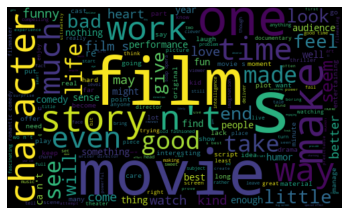

In [ ]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

allWords = ' '.join([twts for twts in df['sentence']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [6]:
train_examples_batch = tf.convert_to_tensor(df['sentence'][:54577])
train_labels_batch = tf.convert_to_tensor(df['label'][:54577])
test_examples_batch = tf.convert_to_tensor(df['sentence'][54577:])
test_labels_batch = tf.convert_to_tensor(df['label'][54577:])
SEQUENCE_LENGTH = 30

In [7]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples_batch)
test_tokens = tokenizer.tokenize(test_examples_batch)

In [8]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:SEQUENCE_LENGTH]
        n_padding = (SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        valid_example_list.append(i)
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return (np.array(texts_vocab_ids), valid_example_list)

In [9]:
train_input_ids, train_valid_example_list = docs_to_vocab_ids(train_tokens)
test_input_ids, test_valid_example_list = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels_batch)
test_input_labels = np.array(test_labels_batch)


Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Total examples:  54576
Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Total examples:  13643


In [10]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

In [ ]:
def create_wan_model(retrain_embeddings=True, 
                     max_sequence_length=SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     learning_rate=0.001):
    """
    Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
    :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
    :param hidden_dim: dimension of the hidden layer
    :param dropout: dropout applied to the hidden layer

    :returns: the compiled model
    """
    wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                  input_length = max_sequence_length,
                                  trainable = retrain_embeddings)
    wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')
    wan_embeddings = wan_embedding_layer(wan_input_layer)

    wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
    wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
    wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
    wan_query_vector = wan_query_layer(wan_batch_of_ones)

    wan_attention_output = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings])
    wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)

    last_hidden_output = wan_attention_output

    if type(hidden_dim) is not list:
        hidden_dim = [hidden_dim]

    for i, h_dim in enumerate(hidden_dim):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu', name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  
    wan_classification = tf.keras.layers.Dense(1, activation='sigmoid', name='dan_classification')(last_hidden_output)

    wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification])

    wan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                       beta_1=0.9,
                                                       beta_2=0.999,
                                                       epsilon=1e-07,
                                                       amsgrad=False,
                                                       name='Adam'),
                    metrics='accuracy')
    
    return wan_model

In [ ]:
wan_model = create_wan_model()

wan_history = wan_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=10,
                            shuffle=True
                            )


Epoch 1/10
1706/1706 [==============================] - 278s 163ms/step - loss: 0.3611 - accuracy: 0.8339 - val_loss: 0.3077 - val_accuracy: 0.8666
Epoch 2/10
1706/1706 [==============================] - 274s 161ms/step - loss: 0.2397 - accuracy: 0.8962 - val_loss: 0.3132 - val_accuracy: 0.8728
Epoch 3/10
1706/1706 [==============================] - 276s 162ms/step - loss: 0.2000 - accuracy: 0.9107 - val_loss: 0.3481 - val_accuracy: 0.8783
Epoch 4/10
1706/1706 [==============================] - 273s 160ms/step - loss: 0.1756 - accuracy: 0.9213 - val_loss: 0.3772 - val_accuracy: 0.8808
Epoch 5/10
1706/1706 [==============================] - 277s 162ms/step - loss: 0.1594 - accuracy: 0.9274 - val_loss: 0.3809 - val_accuracy: 0.8780
Epoch 6/10
1706/1706 [==============================] - 275s 161ms/step - loss: 0.1466 - accuracy: 0.9324 - val_loss: 0.3979 - val_accuracy: 0.8812
Epoch 7/10
1706/1706 [==============================] - 278s 163ms/step - loss: 0.1354 - accuracy: 0.9367 - val_

In [15]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=True):
    cnn_input_layer = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [18]:
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.3
embeddings_trainable = True

cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims,
                            dropout_rate, embeddings_trainable)

cnn_history2 = cnn_model2.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                              batch_size=32,
                              epochs=10
                              )


Epoch 1/10
1706/1706 [==============================] - 373s 218ms/step - loss: 0.4884 - accuracy: 0.7560 - val_loss: 0.3296 - val_accuracy: 0.8576
Epoch 2/10
1706/1706 [==============================] - 371s 218ms/step - loss: 0.2864 - accuracy: 0.8787 - val_loss: 0.2845 - val_accuracy: 0.8805
Epoch 3/10
1706/1706 [==============================] - 371s 217ms/step - loss: 0.2275 - accuracy: 0.9050 - val_loss: 0.2686 - val_accuracy: 0.8907
Epoch 4/10
1706/1706 [==============================] - 374s 219ms/step - loss: 0.1908 - accuracy: 0.9209 - val_loss: 0.2617 - val_accuracy: 0.8956
Epoch 5/10
1706/1706 [==============================] - 372s 218ms/step - loss: 0.1639 - accuracy: 0.9319 - val_loss: 0.2638 - val_accuracy: 0.8983
Epoch 6/10
1706/1706 [==============================] - 378s 222ms/step - loss: 0.1432 - accuracy: 0.9401 - val_loss: 0.2695 - val_accuracy: 0.8991
Epoch 7/10
1706/1706 [==============================] - 378s 222ms/step - loss: 0.1287 - accuracy: 0.9456 - val_

In [14]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=True):
    rnn_input_layer = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

In [17]:
rnn_dim = 100
dense_layer_dims = [100, 100, 50, 25]
dropout_rate = 0.3

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=True)

rnn_history = rnn_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(test_input_ids, test_input_labels),
                            batch_size=32,
                            epochs=10
                            )

Epoch 1/10
1706/1706 [==============================] - 384s 224ms/step - loss: 0.5454 - accuracy: 0.6974 - val_loss: 0.3587 - val_accuracy: 0.8347
Epoch 2/10
1706/1706 [==============================] - 363s 213ms/step - loss: 0.3335 - accuracy: 0.8609 - val_loss: 0.3227 - val_accuracy: 0.8545
Epoch 3/10
1706/1706 [==============================] - 374s 219ms/step - loss: 0.2878 - accuracy: 0.8799 - val_loss: 0.3118 - val_accuracy: 0.8636
Epoch 4/10
1706/1706 [==============================] - 368s 216ms/step - loss: 0.2624 - accuracy: 0.8907 - val_loss: 0.3152 - val_accuracy: 0.8633
Epoch 5/10
1706/1706 [==============================] - 362s 212ms/step - loss: 0.2471 - accuracy: 0.8972 - val_loss: 0.3390 - val_accuracy: 0.8693
Epoch 6/10
1706/1706 [==============================] - 370s 217ms/step - loss: 0.2338 - accuracy: 0.9005 - val_loss: 0.3358 - val_accuracy: 0.8660
Epoch 7/10
1706/1706 [==============================] - 364s 213ms/step - loss: 0.2262 - accuracy: 0.9029 - val_